# Mobile Price Classification Using Spark MLlib

This notebook demonstrates how to perform mobile price classification using PySpark's MLlib. We will preprocess the data, train machine learning models, evaluate them, and visualize the results.

## Import Libraries
First, we import the necessary libraries.


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import pandas as pd

# Load the training data using pandas for initial inspection
df_train = pd.read_csv('train.csv')


## Create Spark Session
We create a Spark session which is the entry point to programming with Spark.


In [3]:
def create_spark_session(app_name="Mobile Price Classification"):
    """
    Create and return a Spark session.
    """
    spark = SparkSession.builder \
        .appName(app_name) \
        .getOrCreate()
    return spark

spark = create_spark_session()


24/06/27 09:07:48 WARN Utils: Your hostname, sumans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.66 instead (on interface en0)
24/06/27 09:07:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/27 09:07:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load Data
We load the dataset into a Spark DataFrame.


In [4]:
def load_data(spark, file_path):
    """
    Load and return the dataset from the given file path.
    """
    return spark.read.csv(file_path, header=True, inferSchema=True)

data = load_data(spark, 'train.csv')


## Preprocess Data
We preprocess the data by assembling feature columns into a single feature vector.


In [5]:
def preprocess_data(data, feature_columns):
    """
    Preprocess the data by assembling feature columns into a feature vector.
    """
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    return assembler.transform(data)

feature_columns = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
                   'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'px_height', 
                   'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 
                   'touch_screen', 'wifi']

data = preprocess_data(data, feature_columns)


## Split Data
We split the data into training and test sets.


In [6]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)


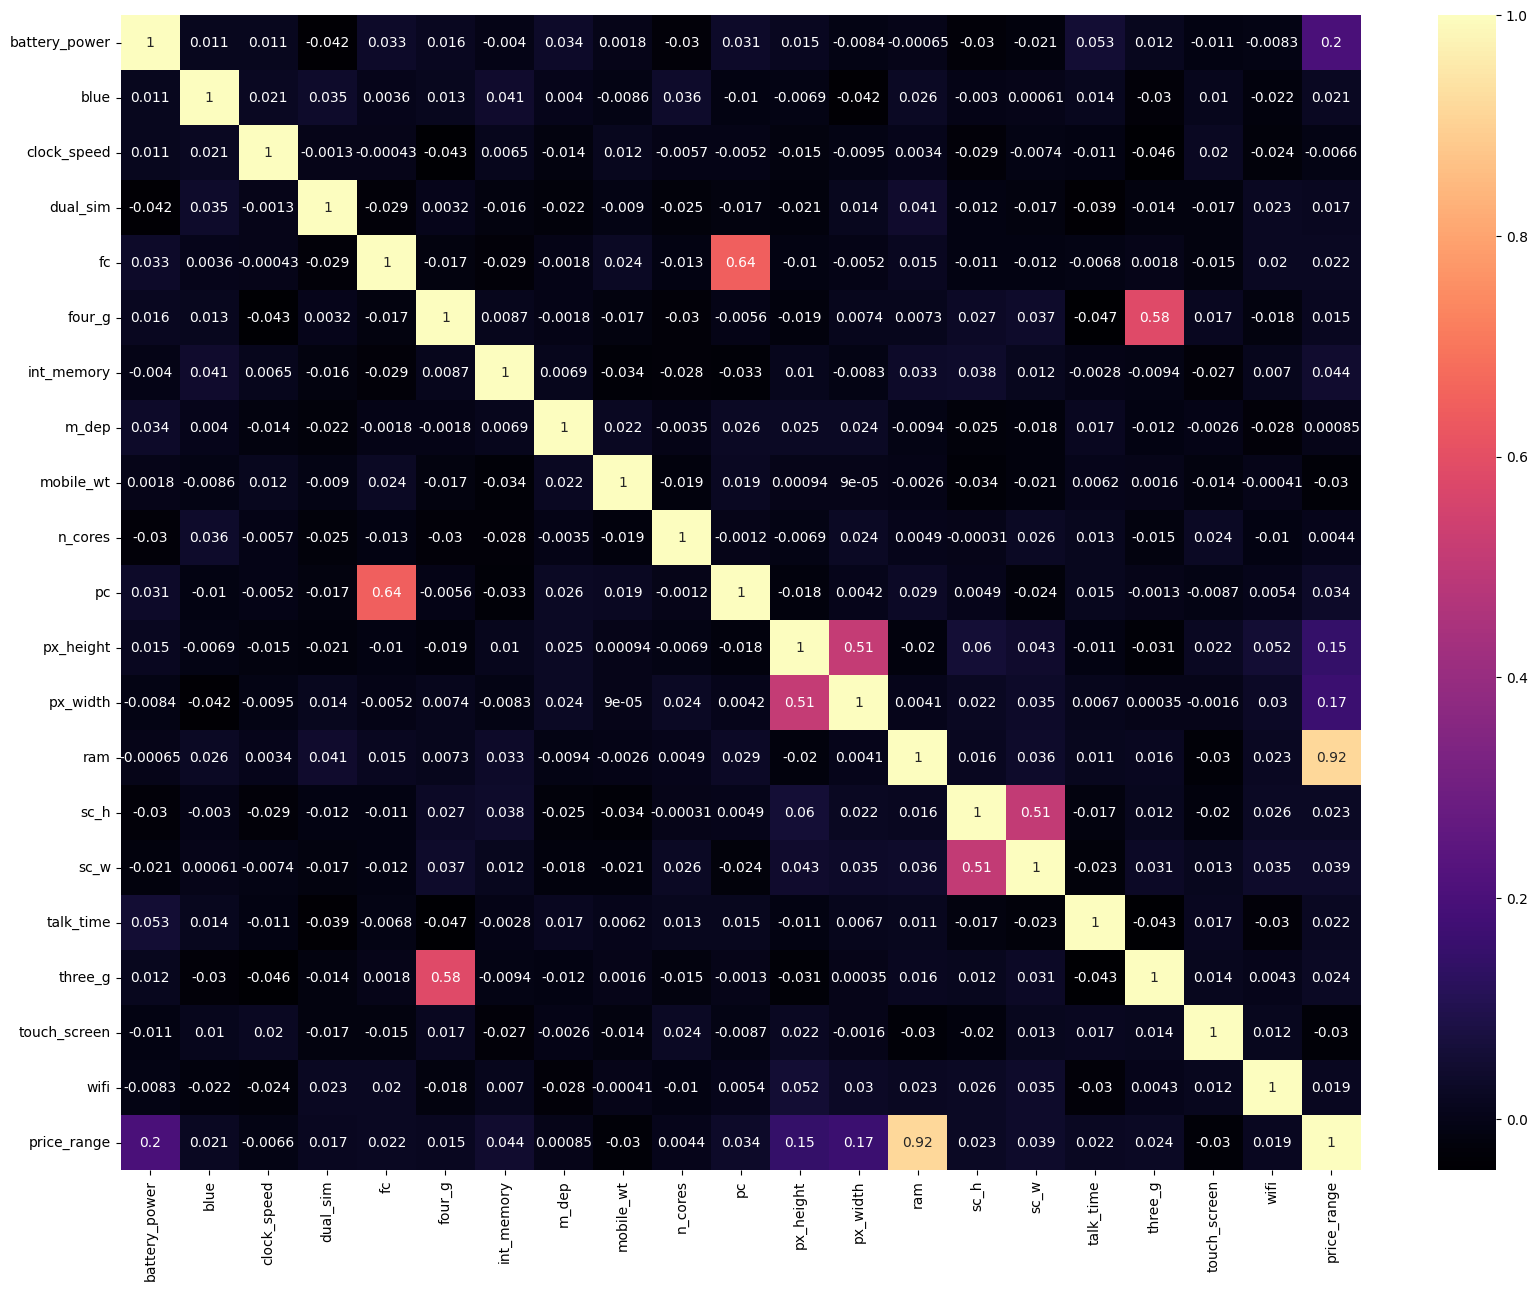

In [15]:
def check_variable_correlation():
    corr_matrix = df_train.corr()
    plt.figure(figsize =(20, 15))
    sns.heatmap(corr_matrix, annot=True, cmap='magma')
    plt.show()

check_variable_correlation()

## Train Random Forest Model
We train a RandomForestClassifier using CrossValidator for hyperparameter tuning.


In [7]:
def train_random_forest(train_data, label_col="price_range", features_col="features"):
    """
    Train a RandomForestClassifier using CrossValidator and return the model.
    """
    rf = RandomForestClassifier(labelCol=label_col, featuresCol=features_col)
    
    paramGrid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 20, 30]) \
        .addGrid(rf.maxDepth, [5, 10, 15]) \
        .build()
    
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    
    crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
    
    cv_model = crossval.fit(train_data)
    
    return cv_model

rf_model = train_random_forest(train_data)


24/06/27 09:07:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/06/27 09:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1055.3 KiB
24/06/27 09:08:01 WARN DAGScheduler: Broadcasting large task binary with size 1062.9 KiB
24/06/27 09:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1070.5 KiB
24/06/27 09:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1287.7 KiB
24/06/27 09:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1070.5 KiB
24/06/27 09:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1287.7 KiB
24/06/27 09:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1454.4 KiB
24/06/27 09:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1523.1 KiB
24/06/27 09:08:04 WARN DAGScheduler: Broadcasting large task binary with size 1365.5 KiB
24/06/27 0

## Evaluate Random Forest Model
We evaluate the RandomForest model's accuracy on the test data.


In [8]:
def evaluate_model(cv_model, test_data, label_col="price_range"):
    """
    Evaluate the model's accuracy on the test data and return the accuracy and predictions.
    """
    predictions = cv_model.transform(test_data)
    
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    return accuracy, predictions

rf_accuracy, rf_predictions = evaluate_model(rf_model, test_data)
print(f"RandomForest Test Accuracy = {rf_accuracy}")


RandomForest Test Accuracy = 0.8427835051546392


24/06/27 09:08:20 WARN DAGScheduler: Broadcasting large task binary with size 1470.7 KiB


## Plot Confusion Matrix for Random Forest
We generate and plot a confusion matrix heatmap for the RandomForest model.


24/06/27 09:08:20 WARN DAGScheduler: Broadcasting large task binary with size 1452.5 KiB


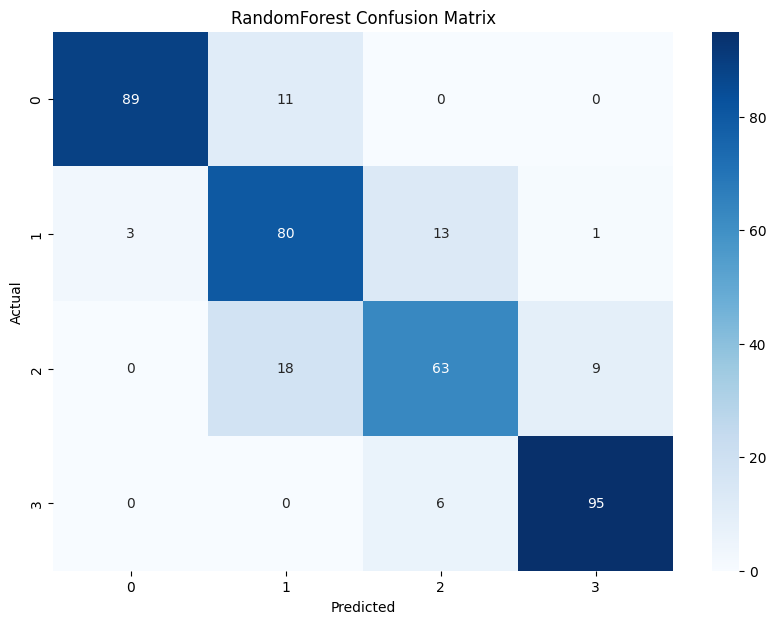

In [9]:
def plot_confusion_matrix(predictions, label_col="price_range", prediction_col="prediction", title="Confusion Matrix"):
    """
    Generate and plot a confusion matrix heatmap.
    """
    preds_and_labels = predictions.select(prediction_col, label_col).collect()
    
    predictions_array = [row[prediction_col] for row in preds_and_labels]
    labels_array = [row[label_col] for row in preds_and_labels]
    
    conf_matrix = confusion_matrix(labels_array, predictions_array)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion_matrix(rf_predictions, title="RandomForest Confusion Matrix")


## Train Logistic Regression Model
We train a LogisticRegression model using CrossValidator for hyperparameter tuning.


In [10]:
def train_logistic_regression(train_data, label_col="price_range", features_col="features"):
    """
    Train a LogisticRegression model using CrossValidator and return the model.
    """
    lr = LogisticRegression(labelCol=label_col, featuresCol=features_col)
    
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
        .build()
    
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    
    crossval = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
    
    cv_model = crossval.fit(train_data)
    
    return cv_model

lr_model = train_logistic_regression(train_data)


24/06/27 09:08:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


## Evaluate Logistic Regression Model
We evaluate the LogisticRegression model's accuracy on the test data.


In [11]:
lr_accuracy, lr_predictions = evaluate_model(lr_model, test_data)
print(f"Logistic Regression Test Accuracy = {lr_accuracy}")


Logistic Regression Test Accuracy = 0.9097938144329897


## Plot Confusion Matrix for Logistic Regression
We generate and plot a confusion matrix heatmap for the LogisticRegression model.


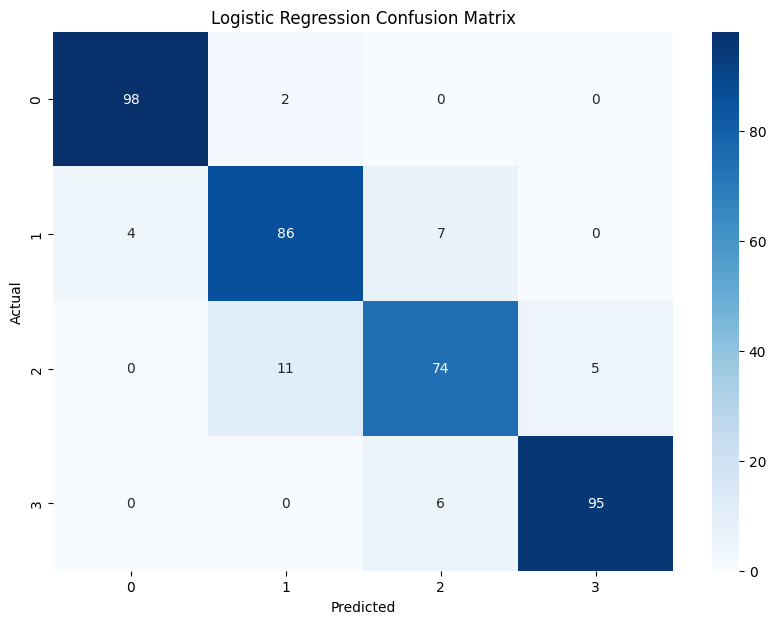

In [12]:
plot_confusion_matrix(lr_predictions, title="Logistic Regression Confusion Matrix")


## Additional Analysis: Q-Q Plots and Correlation Matrix
We perform additional analysis to check the likely distribution and correlation of features.


<Figure size 1600x1600 with 0 Axes>

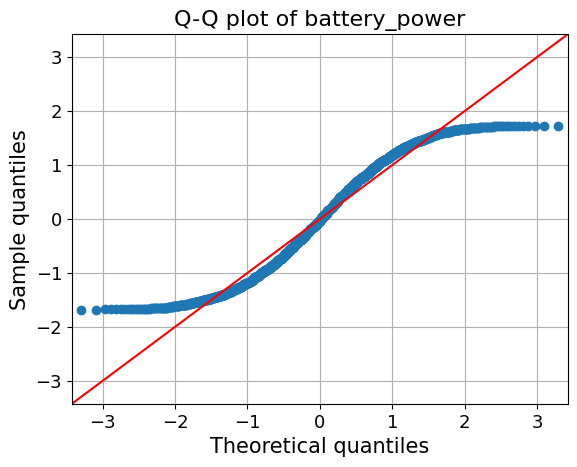

<Figure size 1600x1600 with 0 Axes>

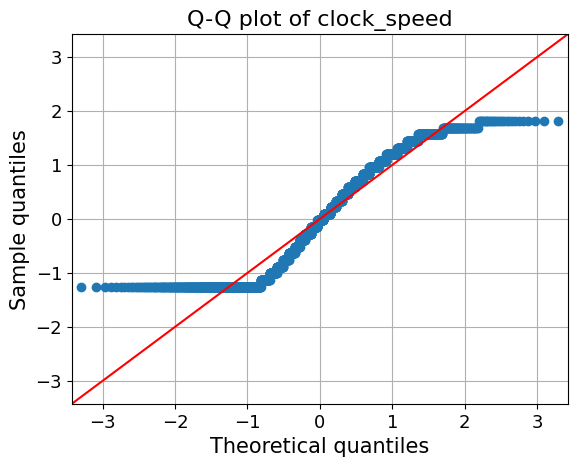

<Figure size 1600x1600 with 0 Axes>

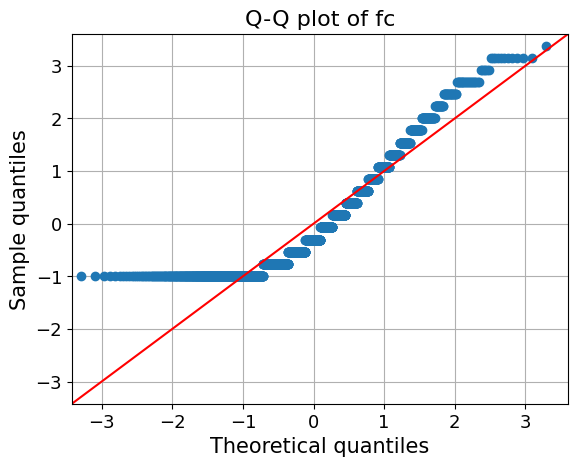

<Figure size 1600x1600 with 0 Axes>

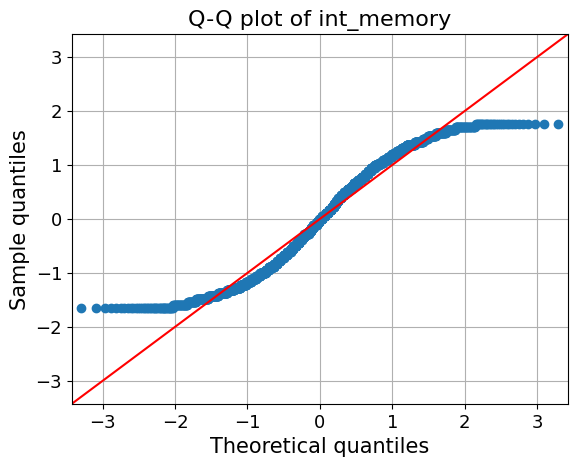

<Figure size 1600x1600 with 0 Axes>

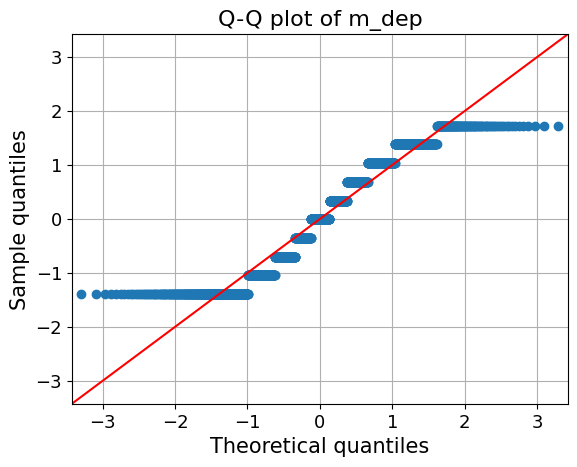

<Figure size 1600x1600 with 0 Axes>

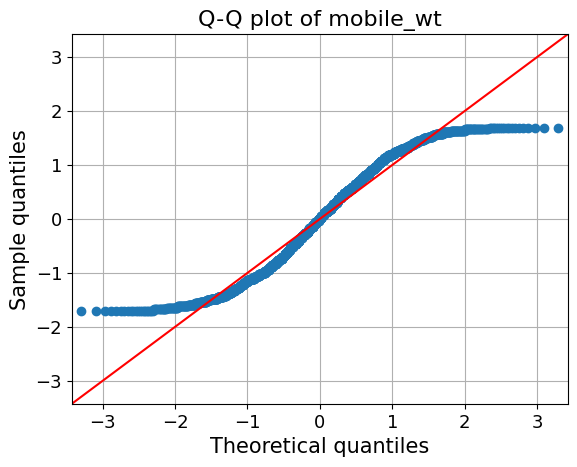

<Figure size 1600x1600 with 0 Axes>

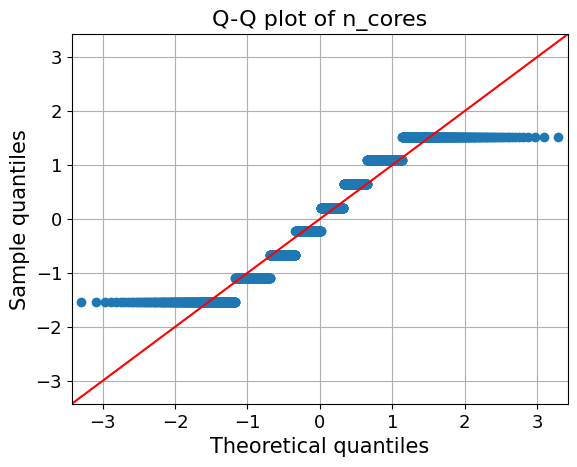

<Figure size 1600x1600 with 0 Axes>

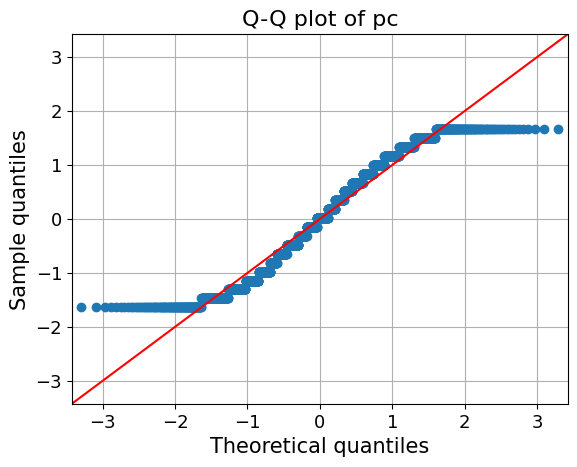

<Figure size 1600x1600 with 0 Axes>

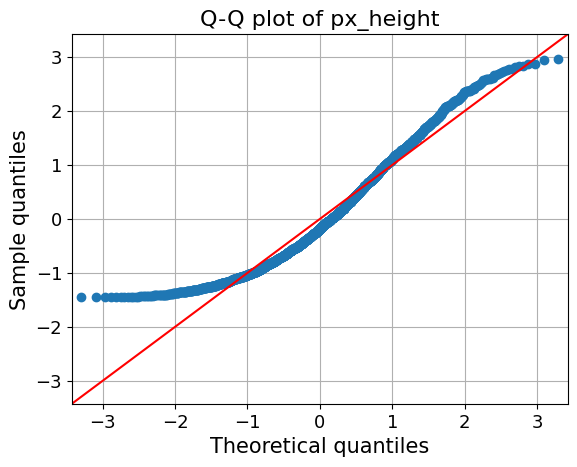

<Figure size 1600x1600 with 0 Axes>

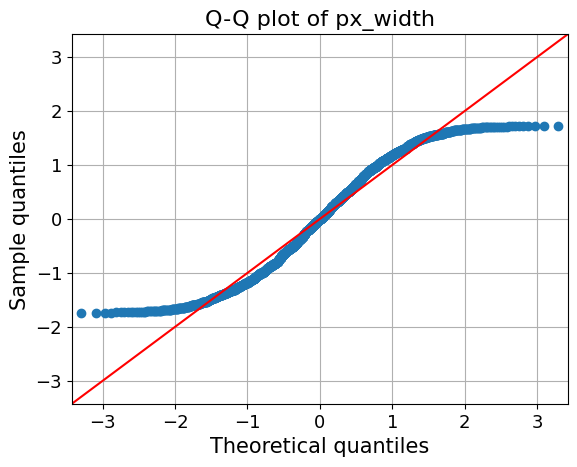

<Figure size 1600x1600 with 0 Axes>

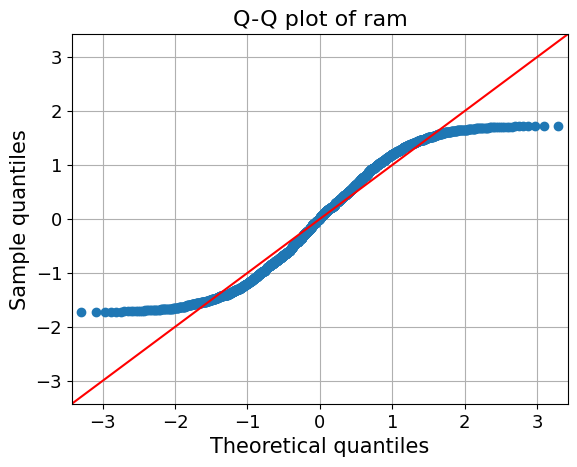

<Figure size 1600x1600 with 0 Axes>

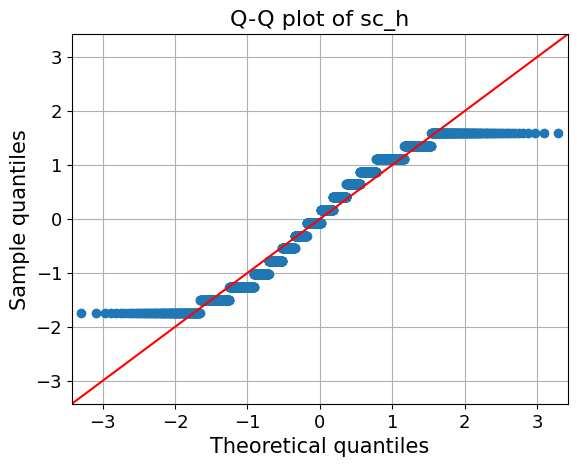

<Figure size 1600x1600 with 0 Axes>

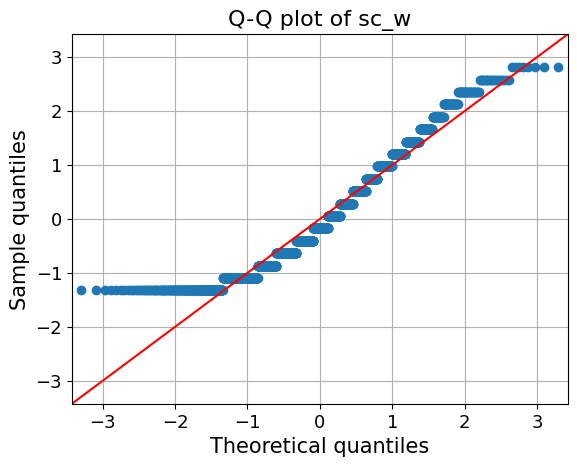

<Figure size 1600x1600 with 0 Axes>

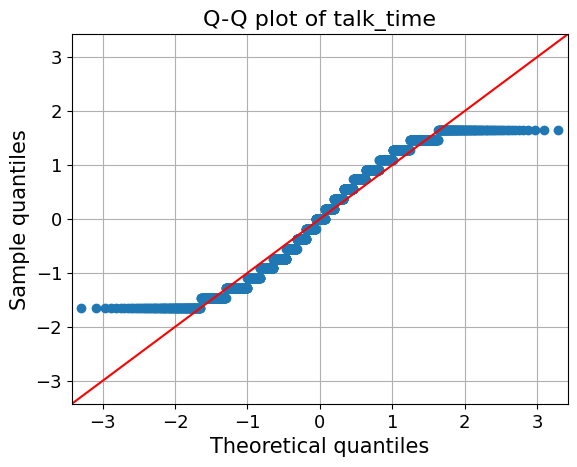

In [13]:
def check_likely_distribution():
    data_norm = df_train[['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 
                'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']]
   
    for c in data_norm.columns:
        plt.figure(figsize=(16,16))
        fig = qqplot(data_norm[c], line='45', fit='True')
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.xlabel("Theoretical quantiles", fontsize=15)
        plt.ylabel("Sample quantiles", fontsize=15)
        plt.title(f"Q-Q plot of {c}", fontsize=16)
        plt.grid(True)
        plt.show()

check_likely_distribution()


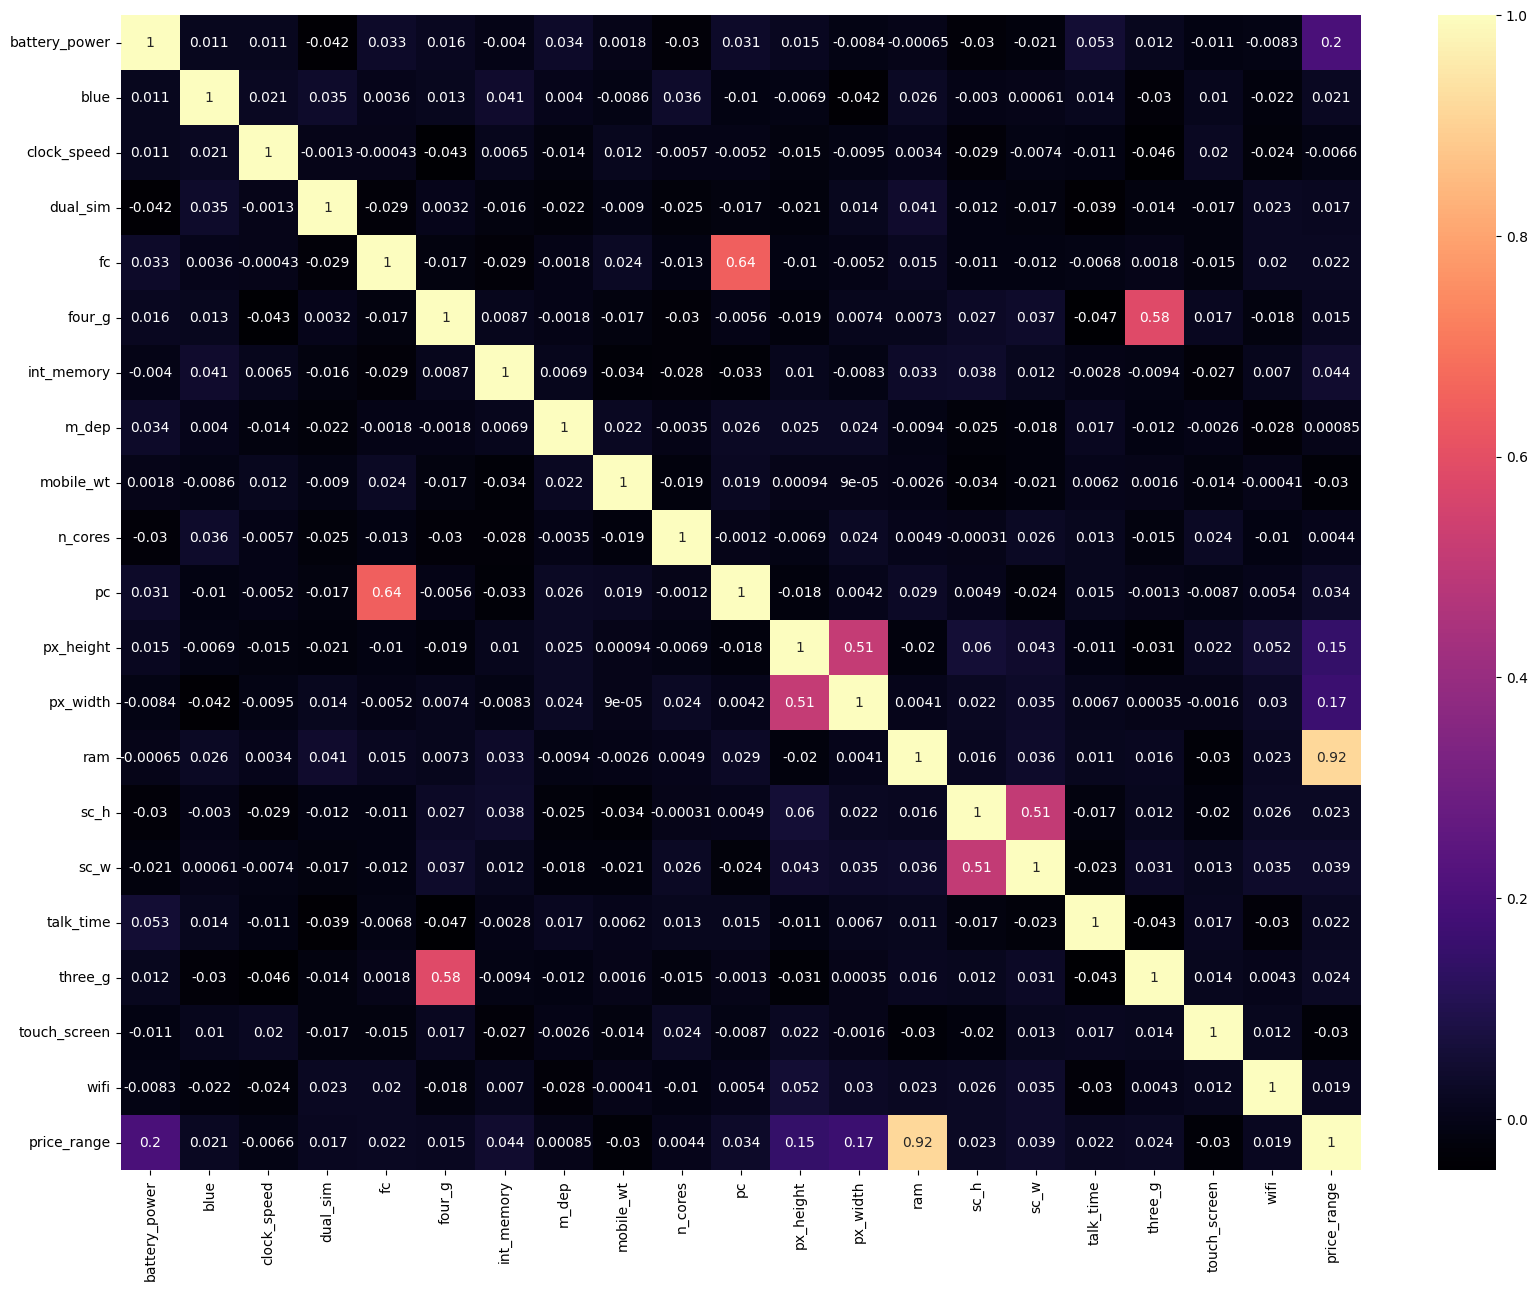

# Summary
In this notebook, we demonstrated the end-to-end process of training and evaluating machine learning models using PySpark's MLlib. We trained RandomForest and LogisticRegression models, evaluated their performance, and visualized the results using confusion matrices. We also conducted additional analysis using Q-Q plots and a correlation matrix to understand the distribution and relationships of features.
